In [1]:
import pandas as pd
import json
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
# import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

plotly.offline.init_notebook_mode(connected=True) 

%matplotlib inline

In [2]:
def read_formatted_jsons(INDIR):
    generation_dfs = []
    stats_dicts = []
    
    for domain in os.listdir(INDIR):
        for fname in glob.glob(INDIR+domain+"/*.json"):

            org_id = os.path.basename(fname).strip(".json")

            with open(fname) as f:
                datajson = json.load(f)

            datajson["stats"]["org_id"] = org_id
            datajson["stats"]["domain"] = domain
            datajson["stats"]["path"] = fname

            stats_dicts.append(datajson["stats"])
            generation_dfs.append(pd.DataFrame(datajson["generations"]))
            
    return generation_dfs, stats_dicts

In [3]:
def read_formatted_json_single(INDIR):
    generation_dfs = []
    stats_dicts = []
    
#     for domain in os.listdir(INDIR):
    for fname in glob.glob(INDIR+"*.json"):

        org_id = os.path.basename(fname).strip(".json")

        with open(fname) as f:
            datajson = json.load(f)

        datajson["stats"]["org_id"] = org_id
        datajson["stats"]["domain"] = domain
        datajson["stats"]["path"] = fname

        stats_dicts.append(datajson["stats"])
        generation_dfs.append(pd.DataFrame(datajson["generations"]))
            
    return generation_dfs, stats_dicts

### Transpose etc.

In [4]:
def twist_dfs(df_list):
    twisted_dfs = []
    for df in df_list:
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()   
        twisted_dfs.append(df)
    return twisted_dfs

### Add `n` columns

In [5]:
def add_n_to_cols(df_list):
    for df in df_list:
        original_columns = df.columns
        for col in original_columns:
            df["n_"+col] = df[col].str.len() 
    return df_list

### Add domain and org_id

In [6]:
def add_domain_and_orgid(df_list,stats_dicts):
    for i,df in enumerate(df_list):
        df['org_id'] = stats_dicts[i]["org_id"]
        df['domain'] = stats_dicts[i]["domain"]
    return df_list

### Add tags if desired

In [7]:
def add_tags(df_list,cpds_to_tag):
    for df in df_list:
        df['tags'] = df['compounds_new'].apply(lambda x: [cpd for cpd in cpds_to_tag if cpd in x])
    return df_list

In [8]:
def cool_plots_many(df,attribute):
    traces = []
    for i in df["org_id"].unique():
        
        traces.append(go.Scatter(
        x = df.loc[df["org_id"]==i].index,
        y = df.loc[df["org_id"]==i][attribute],
        mode = 'lines+markers',
        name = attribute
        ))
    plotly.offline.iplot(traces)   

In [9]:
def cool_plots(df,line1,line2):

    # Create traces
    trace0 = go.Scatter(
        x = df.index,
        y = df[line1],
        mode = 'lines+markers+text',
        name = line1,
        textposition='top center'
    #     text= data['state']
    )
    trace1 = go.Scatter(
        x = df.index,
        y = df[line2],
        mode = 'lines+markers',
        name = line2
    )

    data = [trace0,trace1]
    plotly.offline.iplot(data)

### Main

In [10]:
cpds_to_tag = []

INDIR = "../results/formatted_2019-09-09/ph_edge_jsons/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

In [11]:
len(df.groupby("org_id").max())

294

In [12]:
stats_dicts[0].keys()

dict_keys(['scope_targets', 'scope_reactions', 'scope_compounds', 'scope_seeds', 'org_id', 'domain', 'path'])

## Use stats df and regular df to compile data into sinlge dataframe

In [13]:
stats_df = pd.DataFrame(stats_dicts)

In [14]:
for col in ['scope_targets','scope_compounds']:
    stats_df["n_"+col] = stats_df[col].str.len() 

In [15]:
max_df = df.groupby("org_id").max()

In [16]:
merged_df = pd.merge(max_df.reset_index()[["n_compounds_cumulative","n_targets_cumulative","org_id","domain"]],
        stats_df[["org_id","n_scope_targets","n_scope_compounds"]],
        on="org_id")

In [17]:
merged_df = merged_df.sort_values(["domain","n_scope_compounds"],ascending=False)

In [18]:
merged_df.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds
156,19,0,2554235157,bacteria,60,1800
28,17,0,2517287020,bacteria,60,1749
21,16,0,2515154141,bacteria,60,1727
20,16,0,2515154140,bacteria,60,1698
277,25,0,640753051,bacteria,60,1641


In [19]:
merged_df_nophosphorous = merged_df

In [20]:
merged_df_nophosphorous['P'] = False

In [21]:
merged_df_nophosphorous.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P
156,19,0,2554235157,bacteria,60,1800,False
28,17,0,2517287020,bacteria,60,1749,False
21,16,0,2515154141,bacteria,60,1727,False
20,16,0,2515154140,bacteria,60,1698,False
277,25,0,640753051,bacteria,60,1641,False


### Barplots

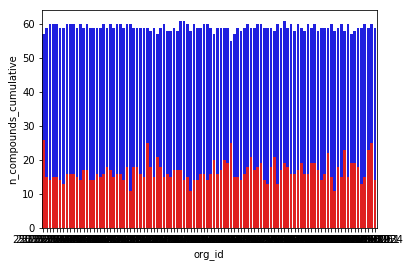

In [22]:
# Plot the total crashes
# sns.set_color_codes("pastel")
sns.barplot(x="org_id", y="n_scope_targets", data=merged_df[:100],
            label="Total network size", color="b")

# Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
sns.barplot(x="org_id", y="n_compounds_cumulative", data=merged_df[:100],
            label="Alcohol-involved", color="r")


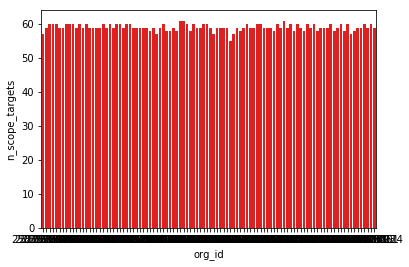

In [23]:
sns.barplot(x="org_id", y="n_scope_targets", data=merged_df[:100],
            label="Alcohol-involved", color="r")

In [24]:
generation_dfs[0][["n_compounds_cumulative","n_targets_cumulative","org_id","domain"]]

,n_compounds_cumulative,n_targets_cumulative,org_id,domain
1,10,0,2593339207,bacteria
2,14,0,2593339207,bacteria
3,15,0,2593339207,bacteria


### Properties of the organisms I ended up analyzing

In [25]:
len(stats_dicts[0].keys())

7

In [26]:
generation_dfs[0].head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id,domain
1,"[C00001, C00014, C00011, C00282, C00469, C0028...","[C00282, C00237, C00014, C00011, C00067, C0143...","[R10092, R00602, R00132]","[R00132, R00602, R10092]",[],[],10,10,3,3,0,0,2593339207,bacteria
2,"[C00080, C00001, C00014, C00288, C00011, C0028...","[C00080, C00288, C00027, C01353]","[R10092, R00602, R00132, R00009]",[R00009],[],[],14,4,4,1,0,0,2593339207,bacteria
3,"[C00080, C00001, C00014, C00288, C00011, C0000...",[C00007],"[R10092, R00602, R00132, R00009]",[],[],[],15,1,4,0,0,0,2593339207,bacteria


In [27]:
for k in ['scope_targets','scope_compounds']:
    print(len(stats_dicts[0][k]))
    print(len(generation_dfs[0]))

58
3
1051
3


In [28]:
stats_dicts[0].keys()

dict_keys(['scope_targets', 'scope_reactions', 'scope_compounds', 'scope_seeds', 'org_id', 'domain', 'path'])

In [29]:
len(stats_dicts)-28

266

### Look at some properties of stats dicts

(array([  2.,   0.,   2.,  13.,  49., 172.,  22.,  11.,  14.,   9.]),
 array([ 2. ,  3.2,  4.4,  5.6,  6.8,  8. ,  9.2, 10.4, 11.6, 12.8, 14. ]),
 <a list of 10 Patch objects>)

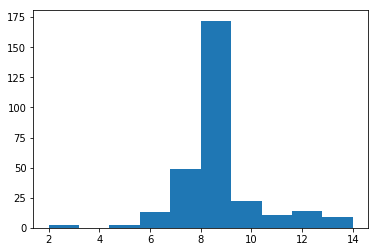

In [30]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([  1.,   1.,   0.,   0.,   0.,   3.,   7.,   6.,  44., 232.]),
 array([16. , 20.5, 25. , 29.5, 34. , 38.5, 43. , 47.5, 52. , 56.5, 61. ]),
 <a list of 10 Patch objects>)

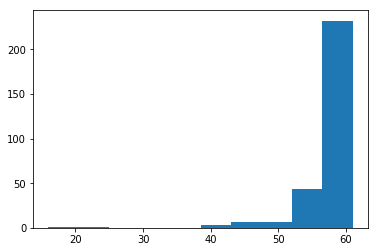

In [31]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([ 2.,  0.,  4., 15., 28., 66., 80., 72., 22.,  5.]),
 array([ 121. ,  288.9,  456.8,  624.7,  792.6,  960.5, 1128.4, 1296.3,
        1464.2, 1632.1, 1800. ]),
 <a list of 10 Patch objects>)

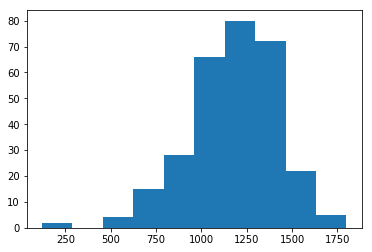

In [32]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([ 2.,  2.,  7.,  9., 27., 68., 66., 78., 30.,  5.]),
 array([  65. ,  224.1,  383.2,  542.3,  701.4,  860.5, 1019.6, 1178.7,
        1337.8, 1496.9, 1656. ]),
 <a list of 10 Patch objects>)

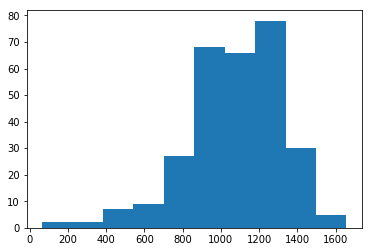

In [33]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

(array([  2.,   7.,  28.,  16.,  37., 134.,  39.,  20.,   7.,   4.]),
 array([ 2. ,  4.4,  6.8,  9.2, 11.6, 14. , 16.4, 18.8, 21.2, 23.6, 26. ]),
 <a list of 10 Patch objects>)

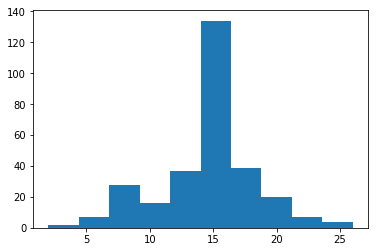

In [34]:
plt.hist([merged_df["n_compounds_cumulative"]])

(array([  2.,   7.,  28.,  16.,  37., 134.,  39.,  20.,   7.,   4.]),
 array([ 2. ,  4.4,  6.8,  9.2, 11.6, 14. , 16.4, 18.8, 21.2, 23.6, 26. ]),
 <a list of 10 Patch objects>)

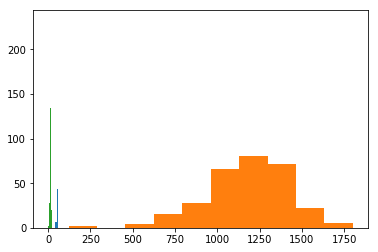

In [35]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])
plt.hist([len(d['scope_compounds']) for d in stats_dicts])
plt.hist([merged_df["n_compounds_cumulative"]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12dfc8a20>,
      dtype=object)

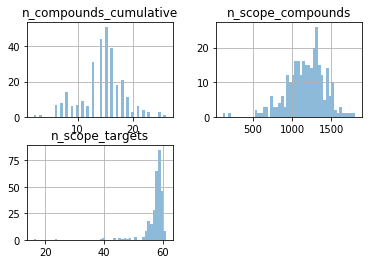

In [36]:
merged_df[['n_compounds_cumulative','n_scope_targets','n_scope_compounds']].hist(alpha=.5,bins=50)

## Font properties

In [37]:
color_order = ['blue' if domain=='bacteria' else 'orange' for domain in df["domain"]]


In [38]:
df["color"] = color_order

In [39]:
font = {'size'   : 16}
# 'family' : 'normal',
#         'weight' : 'bold',
       

mpl.rc('font', **font)

In [40]:
len(stats_dicts)

294

stats_dicts[0]

In [41]:
# stats_dicts[0]

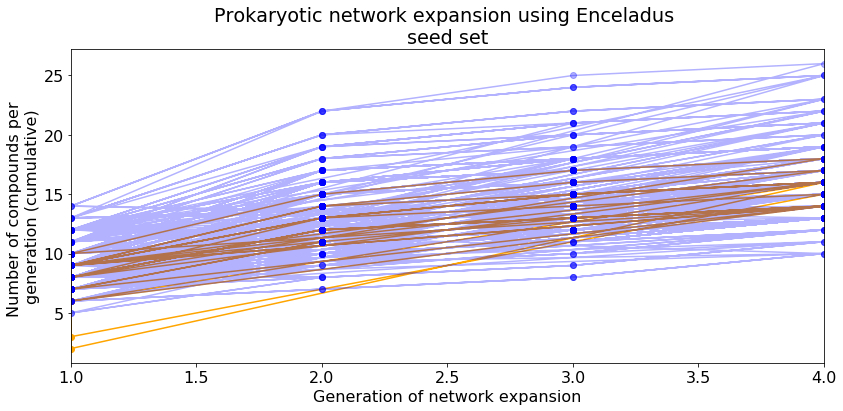

In [42]:
# plt.figure(facecolor='w')
ax = df.loc[df["domain"]=="archaea"].reset_index().plot(kind="line",x="index",y="n_compounds_cumulative", style='-o',color="orange",figsize=(12,6),legend=False)
df.loc[df["domain"]=="bacteria"].reset_index().plot(kind="line",x="index",y="n_compounds_cumulative", style='-o',color="blue",ax=ax, alpha=.3,legend=False)

ax.set_facecolor("white")
ax.set_title("Prokaryotic network expansion using Enceladus \nseed set")
ax.set_xlabel("Generation of network expansion")
ax.set_ylabel("Number of compounds per \ngeneration (cumulative)")
plt.tight_layout()

# plt.legend(False)


In [39]:
# cool_plots_many(df,'n_compounds_cumulative')

## Check seeds that contain phosphorous

In [43]:
INDIR = "../results/formatted_2019-09-09/ph_edge_jsons_P/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

### Make merged df of phosphorous data

In [44]:
stats_df = pd.DataFrame(stats_dicts)

In [45]:
for col in ['scope_targets','scope_compounds']:
    stats_df["n_"+col] = stats_df[col].str.len() 

In [46]:
max_df = df.groupby("org_id").max()

In [47]:
merged_df = pd.merge(max_df.reset_index()[["n_compounds_cumulative","n_targets_cumulative","org_id","domain"]],
        stats_df[["org_id","n_scope_targets","n_scope_compounds"]],
        on="org_id")

In [48]:
merged_df = merged_df.sort_values(["domain","n_scope_compounds"],ascending=False)

In [49]:
merged_df.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds
156,22,0,2554235157,bacteria,60,1800
28,19,0,2517287020,bacteria,60,1749
21,18,0,2515154141,bacteria,60,1727
20,18,0,2515154140,bacteria,60,1698
277,28,0,640753051,bacteria,60,1641


In [50]:
merged_df_phosphorous = merged_df

In [51]:
merged_df_phosphorous['P'] = True

In [52]:
merged_df_phosphorous.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P
156,22,0,2554235157,bacteria,60,1800,True
28,19,0,2517287020,bacteria,60,1749,True
21,18,0,2515154141,bacteria,60,1727,True
20,18,0,2515154140,bacteria,60,1698,True
277,28,0,640753051,bacteria,60,1641,True


### Put P and no P dfs together

In [53]:
for col in merged_df_phosphorous.columns:
    merged_df_phosphorous.rename(columns={col: col+'_P'}, inplace=True)

In [54]:
merged_df_phosphorous.head()

,n_compounds_cumulative_P,n_targets_cumulative_P,org_id_P,domain_P,n_scope_targets_P,n_scope_compounds_P,P_P
156,22,0,2554235157,bacteria,60,1800,True
28,19,0,2517287020,bacteria,60,1749,True
21,18,0,2515154141,bacteria,60,1727,True
20,18,0,2515154140,bacteria,60,1698,True
277,28,0,640753051,bacteria,60,1641,True


In [55]:
pnp_df = pd.merge(merged_df_nophosphorous,merged_df_phosphorous,left_on="org_id",right_on="org_id_P")

In [56]:
# pnp_df = pd.concat([merged_df_nophosphorous,merged_df_phosphorous])

In [57]:
pnp_df.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P,n_compounds_cumulative_P,n_targets_cumulative_P,org_id_P,domain_P,n_scope_targets_P,n_scope_compounds_P,P_P
0,19,0,2554235157,bacteria,60,1800,False,22,0,2554235157,bacteria,60,1800,True
1,17,0,2517287020,bacteria,60,1749,False,19,0,2517287020,bacteria,60,1749,True
2,16,0,2515154141,bacteria,60,1727,False,18,0,2515154141,bacteria,60,1727,True
3,16,0,2515154140,bacteria,60,1698,False,18,0,2515154140,bacteria,60,1698,True
4,25,0,640753051,bacteria,60,1641,False,28,0,640753051,bacteria,60,1641,True


In [58]:
# pnp_df.rename(columns={'n_compounds_cumulative': 'No P', 'n_compounds_cumulative_P': 'P'}, inplace=True)

### New version of figure attempted below...

In [59]:
orgid_domain_dict = dict(pnp_df.groupby("org_id").min()["domain"])

In [60]:
orgid_rank_order = [org for org in pnp_df.groupby("org_id").min()["n_compounds_cumulative"].sort_values().keys()]


In [61]:
color_rank_order = ['blue' if domain=='bacteria' else 'orange' for domain in [orgid_domain_dict[org] for org in orgid_rank_order]]


Text(0, 0.5, 'Number of compounds')

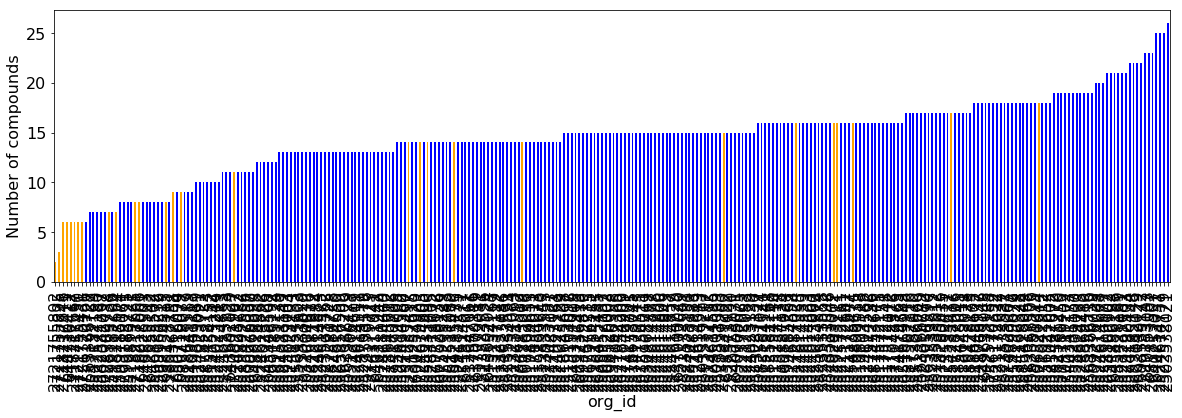

In [62]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
ax = pnp_df.groupby("org_id").min()["n_compounds_cumulative"].sort_values().plot(kind="bar",figsize=(20,5),color=color_rank_order)
ax.set_ylabel("Number of compounds")

Text(0, 0.5, 'Number of compounds')

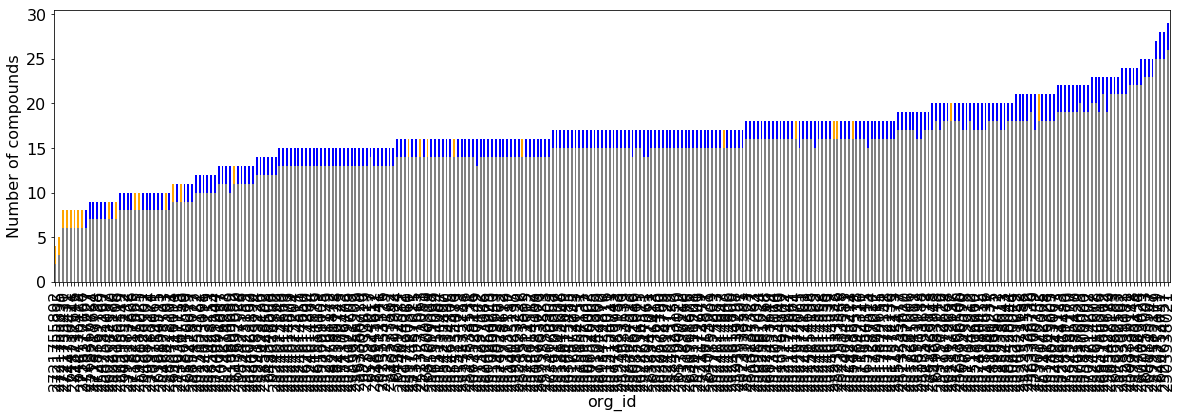

In [63]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
ax = pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values().plot(kind="bar",figsize=(20,5),color=color_rank_order)
pnp_df.groupby("org_id").min()["n_compounds_cumulative"].reindex(pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values().index).plot(kind="bar",figsize=(20,5),ax=ax,color="gray")

ax.set_ylabel("Number of compounds")


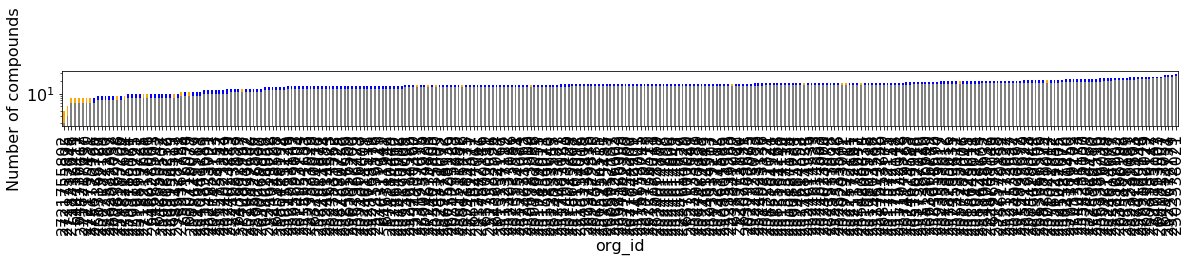

In [64]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
# plt.figure(figsize=(20,1))
ax = pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values().plot(kind="bar",figsize=(20,1),color=color_rank_order)
pnp_df.groupby("org_id").min()["n_compounds_cumulative"].sort_values().plot(kind="bar",ax=ax,color="gray")
ax.set_ylabel("Number of compounds")
ax.set_yscale("log")



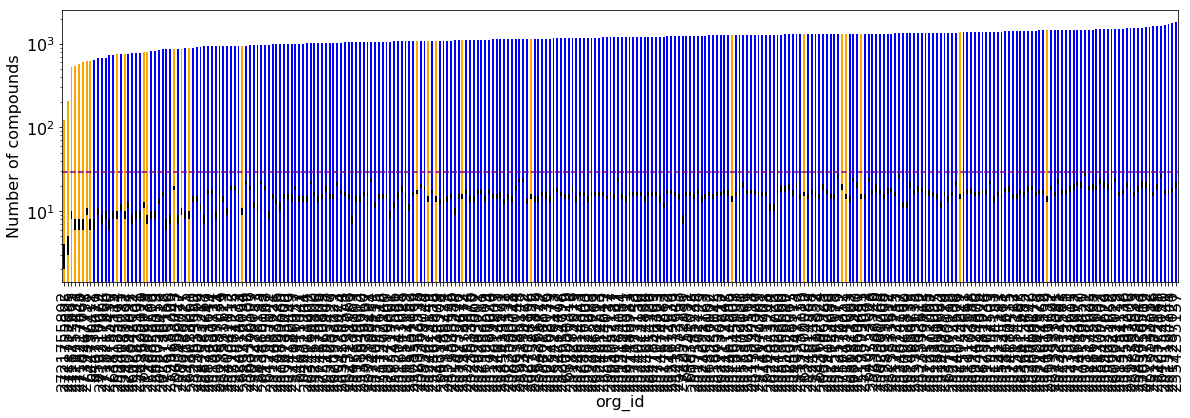

In [65]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color=color_rank_order)
pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].reindex(pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().index).plot(kind="bar",ax=ax,color="black")
pnp_df.groupby("org_id").min()["n_compounds_cumulative"].reindex(pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().index).plot(kind="bar",ax=ax,color=color_rank_order,alpha=1)
ax.axhline(y=max(pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values()),color="purple",linestyle="--")#, xmin=0, xmax=1)
ax.set_ylabel("Number of compounds")
ax.set_yscale("log")


In [66]:
pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values()

org_id
2721755892     121
2721755895     204
2718217665     528
2721755431     545
2718217646     575
2718217667     604
2739367758     625
644736412      628
644736411      642
650716079      679
2718217664     681
2718217666     683
2721755430     739
638154515      740
2599185174     751
2524023091     753
2599185232     756
2740891997     759
2602042032     768
2546825502     773
2585428191     775
643692029      802
2728369738     805
2546825503     818
2565956519     829
648028058      832
2622736413     854
2756170166     857
2599185206     866
649633043      868
              ... 
2517572175    1464
2523533611    1464
2571042005    1464
2524614677    1465
2574180450    1467
2503538021    1470
2521172622    1471
2518645605    1478
2521172637    1484
2558309102    1499
2585427672    1499
2554235029    1505
2556921652    1505
2602042029    1511
2513237112    1514
2515154138    1521
2582581270    1527
2517287006    1527
2523533533    1528
2585428043    1533
2565956516    1534
27037

In [67]:
pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().index

Index(['2721755892', '2721755895', '2718217665', '2721755431', '2718217646',
       '2718217667', '2739367758', '644736412', '644736411', '650716079',
       ...
       '2565956516', '2703719202', '2523533532', '2515154016', '2522572188',
       '640753051', '2515154140', '2515154141', '2517287020', '2554235157'],
      dtype='object', name='org_id', length=294)

### series aren't lined up after sorting, have to reindex
### let's instead plot percentages

In [68]:
cpd_scope = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values()

In [69]:
cpd_cum = pnp_df.groupby("org_id").min()["n_compounds_cumulative"].reindex(pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().index)


In [70]:
cpd_cump = pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].reindex(pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().index)


In [71]:
(cpd_cum/cpd_scope).sort_values()

org_id
2522572180    0.005645
2547132169    0.006724
2756170166    0.007001
2582581267    0.007471
2703719061    0.007547
2627853722    0.007770
2524023244    0.007770
2563366727    0.008046
2599185206    0.008083
2519899682    0.008118
2721755430    0.008119
642555142     0.008188
2518645589    0.008189
2630968890    0.008258
2524023192    0.008258
2519899721    0.008484
2728369738    0.008696
648028061     0.008969
2561511139    0.009003
2599185225    0.009029
2524614883    0.009053
2602042032    0.009115
2515154141    0.009265
2515154016    0.009323
2515154133    0.009326
644736411     0.009346
2515154152    0.009355
2515154140    0.009423
650716094     0.009464
2540341113    0.009534
                ...   
2506520044    0.015789
2516143028    0.015962
2721755892    0.016529
2651869948    0.016683
2585428044    0.016713
2524614533    0.016860
2509887034    0.016967
2513237114    0.017021
2687453649    0.017058
640753003     0.017437
2681813507    0.017464
2622736413    0.017564
2503

In [72]:
(cpd_cump/cpd_scope).reindex((cpd_cum/cpd_scope).sort_values().index)

org_id
2522572180    0.007258
2547132169    0.008646
2756170166    0.009335
2582581267    0.009605
2703719061    0.009434
2627853722    0.009324
2524023244    0.009324
2563366727    0.010345
2599185206    0.010393
2519899682    0.009594
2721755430    0.010825
642555142     0.010235
2518645589    0.010009
2630968890    0.009760
2524023192    0.009760
2519899721    0.010604
2728369738    0.011180
648028061     0.011211
2561511139    0.010388
2599185225    0.011287
2524614883    0.010700
2602042032    0.011719
2515154141    0.010423
2515154016    0.010566
2515154133    0.010760
644736411     0.012461
2515154152    0.011225
2515154140    0.010601
650716094     0.011567
2540341113    0.011653
                ...   
2506520044    0.017544
2516143028    0.018779
2721755892    0.033058
2651869948    0.019627
2585428044    0.018570
2524614533    0.018967
2509887034    0.019088
2513237114    0.019149
2687453649    0.019190
640753003     0.018954
2681813507    0.018983
2622736413    0.019906
2503

#### relevant: https://stackoverflow.com/questions/21912197/setting-different-error-bar-colors-in-bar-plot-in-matplotlib

Text(0, 0.5, 'Fraction of scope compounds')

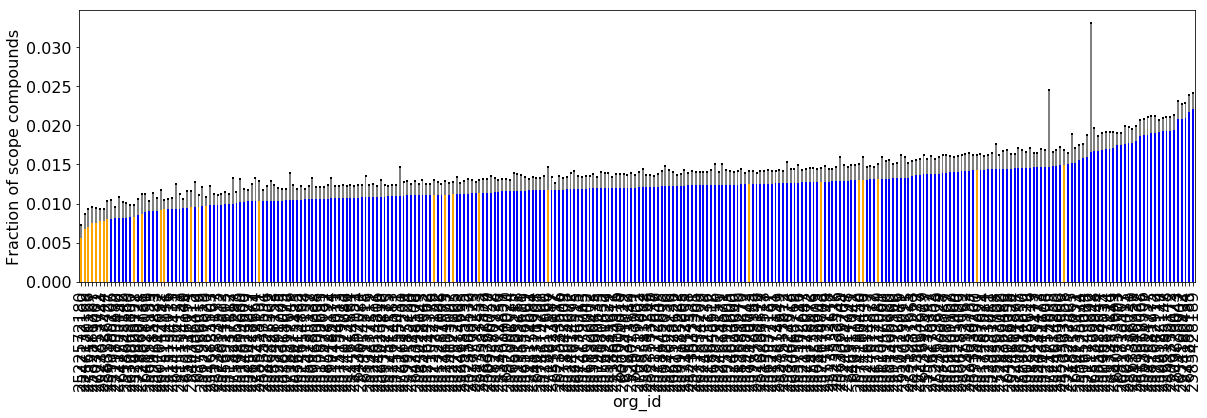

In [73]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
ax = (cpd_cump/cpd_scope).reindex((cpd_cum/cpd_scope).sort_values().index).plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=2),figsize=(20,5),color="gray")
ax2 = (cpd_cum/cpd_scope).sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)

ax.set_ylabel("Fraction of scope compounds")


Text(0, 0.5, 'Number of scope compounds')

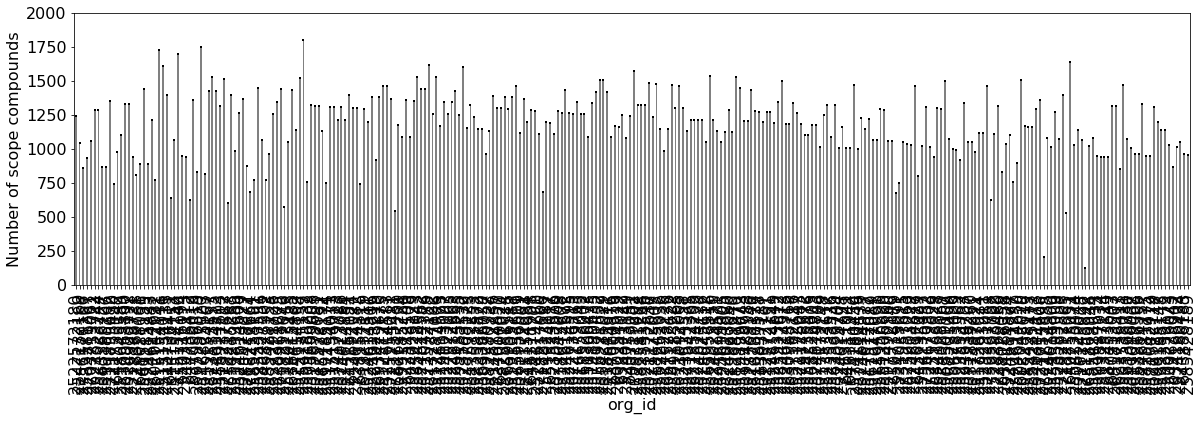

In [74]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
ax = cpd_scope.reindex((cpd_cum/cpd_scope).sort_values().index).plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=2),figsize=(20,5),color="gray")
# ax2 = (cpd_cum/cpd_scope).sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)

ax.set_ylim(0,2000)
ax.set_ylabel("Number of scope compounds")


In [75]:
cpd_scope

org_id
2721755892     121
2721755895     204
2718217665     528
2721755431     545
2718217646     575
2718217667     604
2739367758     625
644736412      628
644736411      642
650716079      679
2718217664     681
2718217666     683
2721755430     739
638154515      740
2599185174     751
2524023091     753
2599185232     756
2740891997     759
2602042032     768
2546825502     773
2585428191     775
643692029      802
2728369738     805
2546825503     818
2565956519     829
648028058      832
2622736413     854
2756170166     857
2599185206     866
649633043      868
              ... 
2517572175    1464
2523533611    1464
2571042005    1464
2524614677    1465
2574180450    1467
2503538021    1470
2521172622    1471
2518645605    1478
2521172637    1484
2558309102    1499
2585427672    1499
2554235029    1505
2556921652    1505
2602042029    1511
2513237112    1514
2515154138    1521
2582581270    1527
2517287006    1527
2523533533    1528
2585428043    1533
2565956516    1534
27037

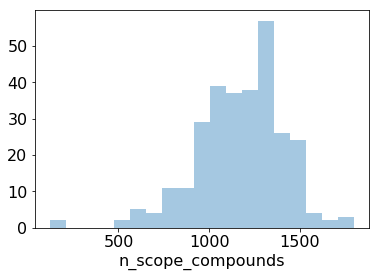

In [76]:
sns.distplot(cpd_scope,hist=True,kde=False)

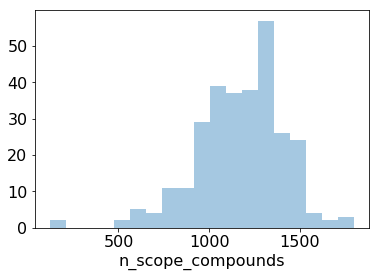

In [77]:
sns.distplot(pnp_df["n_scope_compounds"],hist=True,kde=False)

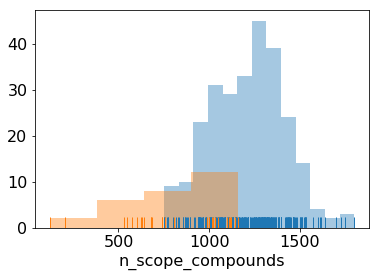

In [78]:
ax = sns.distplot(pnp_df.loc[pnp_df["domain"]=="bacteria"]["n_scope_compounds"],hist=True,kde=False,rug=True)
sns.distplot(pnp_df.loc[pnp_df["domain"]=="archaea"]["n_scope_compounds"],hist=True,kde=False,rug=True,ax=ax)

In [79]:
[i for i in range(2050) if i%50==0];

[0,
 50,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 1000,
 1050,
 1100,
 1150,
 1200,
 1250,
 1300,
 1350,
 1400,
 1450,
 1500,
 1550,
 1600,
 1650,
 1700,
 1750,
 1800,
 1850,
 1900,
 1950,
 2000]

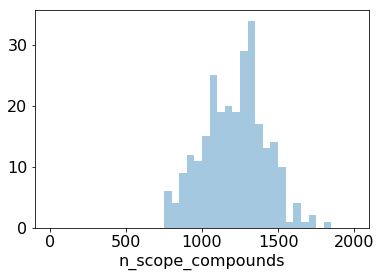

In [80]:
ax = sns.distplot(pnp_df.loc[pnp_df["domain"]=="bacteria"]["n_scope_compounds"],hist=True,kde=False,bins=[i for i in range(2050) if i%50==0])


(0, 2000)

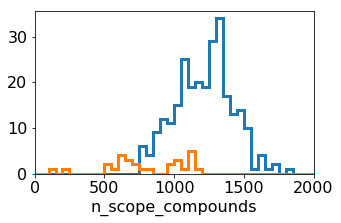

In [81]:
plt.figure(figsize=(5,3))
ax = sns.distplot(pnp_df.loc[pnp_df["domain"]=="bacteria"]["n_scope_compounds"],hist=True,kde=False,bins=[i for i in range(2050) if i%50==0],hist_kws={"histtype": "step","linewidth": 3,"alpha":1})
sns.distplot(pnp_df.loc[pnp_df["domain"]=="archaea"]["n_scope_compounds"],hist=True,kde=False,ax=ax,bins=[i for i in range(2050) if i%50==0],hist_kws={"histtype": "step","linewidth": 3,"alpha":1})
ax.set_xlim(0,2000)


In [82]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

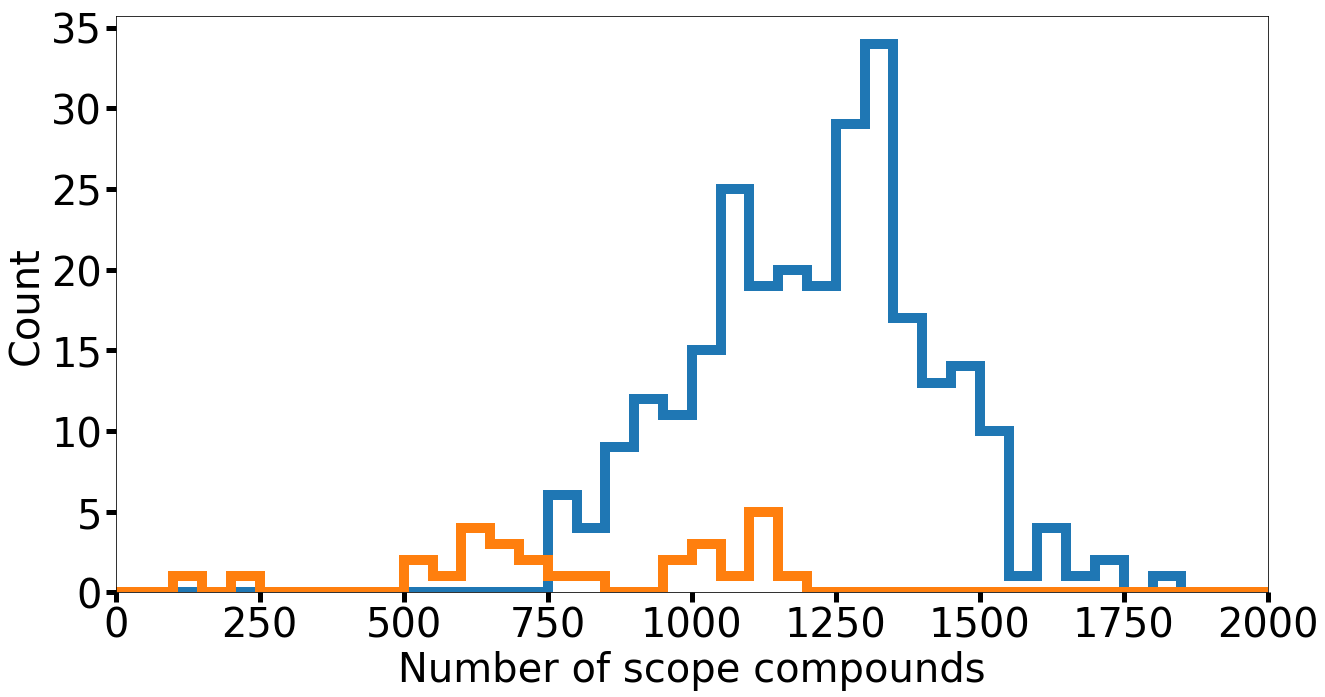

In [83]:
fig, ax=plt.subplots()

ax = sns.distplot(pnp_df.loc[pnp_df["domain"]=="bacteria"]["n_scope_compounds"],hist=True,kde=False,bins=[i for i in range(2050) if i%50==0],hist_kws={"histtype": "step","linewidth": 10,"alpha":1})
sns.distplot(pnp_df.loc[pnp_df["domain"]=="archaea"]["n_scope_compounds"],hist=True,kde=False,ax=ax,bins=[i for i in range(2050) if i%50==0],hist_kws={"histtype": "step","linewidth": 10,"alpha":1})
ax.set_xlim(0,2000)

set_size(16,8)
ax.set_xlabel("Number of scope compounds")
ax.set_ylabel("Count")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)
ax.tick_params(axis='both', length=10,width=5)
plt.show()

Text(0, 0.5, 'Fraction of scope compounds')

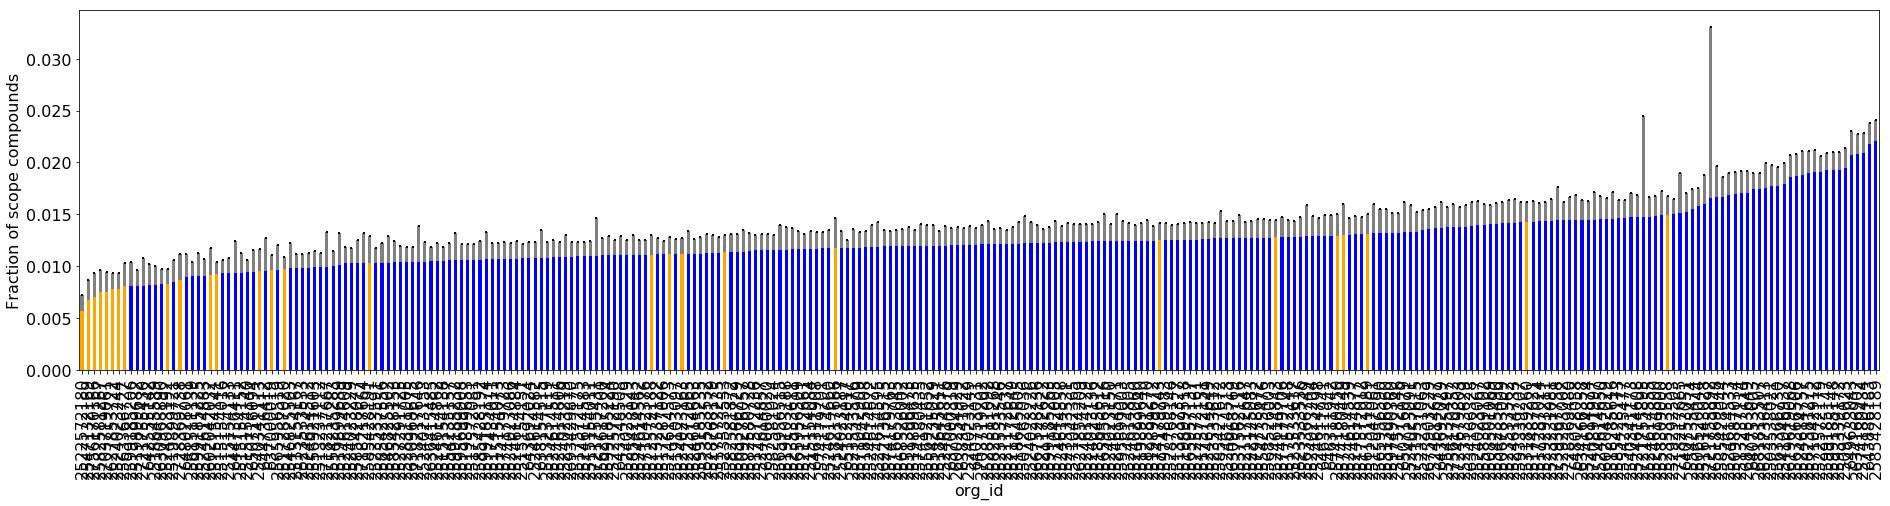

In [84]:
ax = (cpd_cump/cpd_scope).reindex((cpd_cum/cpd_scope).sort_values().index).plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=2),color="gray")
ax2 = (cpd_cum/cpd_scope).sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)

set_size(25,5)
ax.set_ylabel("Fraction of scope compounds")



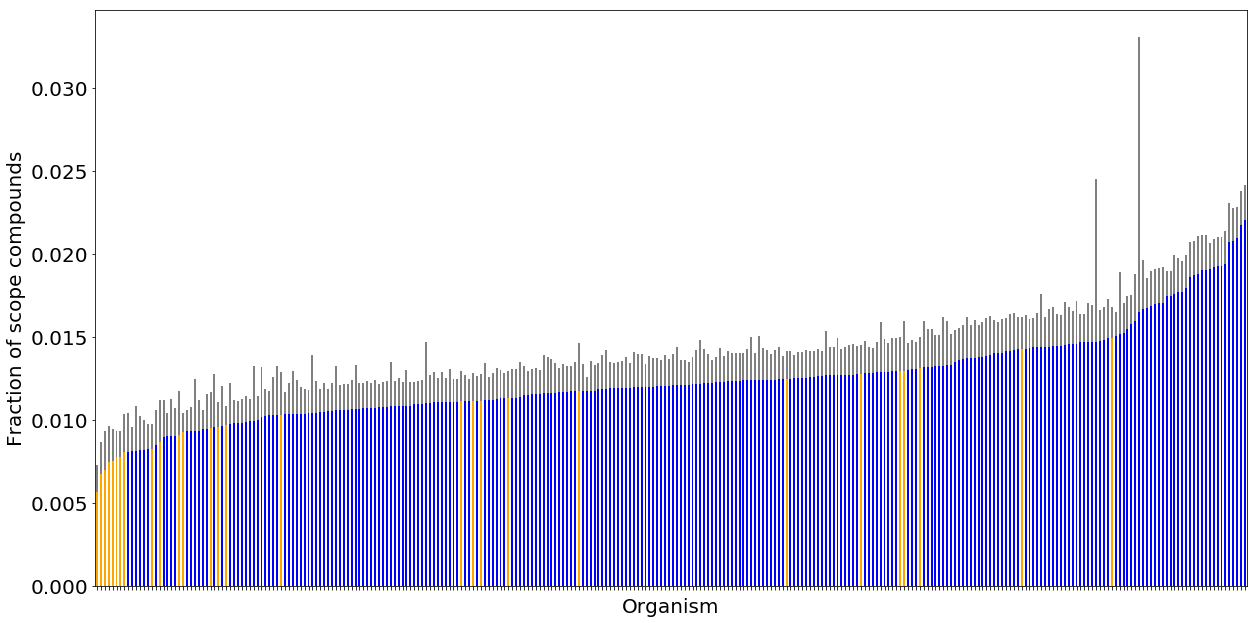

In [85]:
ax = (cpd_cump/cpd_scope).reindex((cpd_cum/cpd_scope).sort_values().index).plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],width=.5,color="gray")
#error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=1),
ax2 = (cpd_cum/cpd_scope).sort_values().plot(kind="bar",ax=ax,width=.5,color=color_rank_order)



set_size(16,8)
ax.set_ylabel("Fraction of scope compounds")
ax.set_xlabel("Organism")
ax.xaxis.set_major_formatter(plt.NullFormatter())
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)


Text(0, 0.5, 'Number of scope compounds')

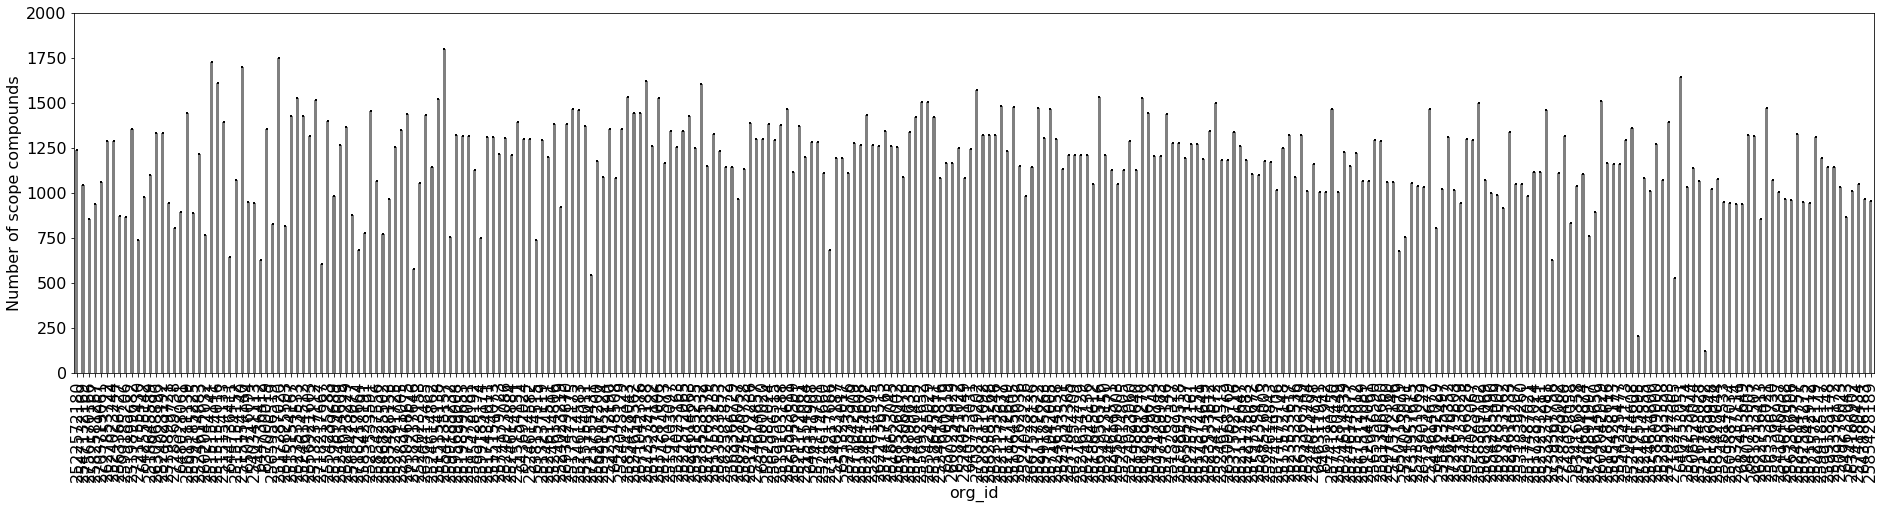

In [86]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
ax = cpd_scope.reindex((cpd_cum/cpd_scope).sort_values().index).plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=2),color="gray")
# ax2 = (cpd_cum/cpd_scope).sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)

ax.set_ylim(0,2000)
set_size(25,5)
ax.set_ylabel("Number of scope compounds")


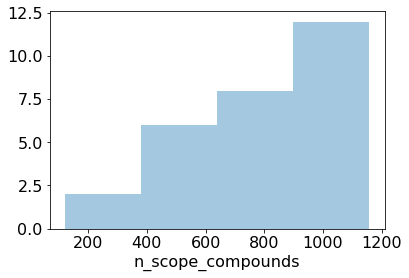

In [87]:
sns.distplot(pnp_df.loc[pnp_df["domain"]=="archaea"]["n_scope_compounds"],hist=True,kde=False)
# sns.distplot(pnp_df.loc[pnp_df["domain"]=="archaea"]["n_scope_compounds"],hist=True,kde=False,ax=ax)

In [88]:
len(pnp_df.loc[pnp_df["domain"]=="archaea"])

28

In [89]:
len(pnp_df.loc[pnp_df["domain"]=="bacteria"])

266

In [90]:
pnp_df.loc[pnp_df["domain"]=="bacteria"].head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P,n_compounds_cumulative_P,n_targets_cumulative_P,org_id_P,domain_P,n_scope_targets_P,n_scope_compounds_P,P_P
0,19,0,2554235157,bacteria,60,1800,False,22,0,2554235157,bacteria,60,1800,True
1,17,0,2517287020,bacteria,60,1749,False,19,0,2517287020,bacteria,60,1749,True
2,16,0,2515154141,bacteria,60,1727,False,18,0,2515154141,bacteria,60,1727,True
3,16,0,2515154140,bacteria,60,1698,False,18,0,2515154140,bacteria,60,1698,True
4,25,0,640753051,bacteria,60,1641,False,28,0,640753051,bacteria,60,1641,True


/Users/anarres/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/Users/anarres/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



Text(0.5, 0, 'Number of compounds')

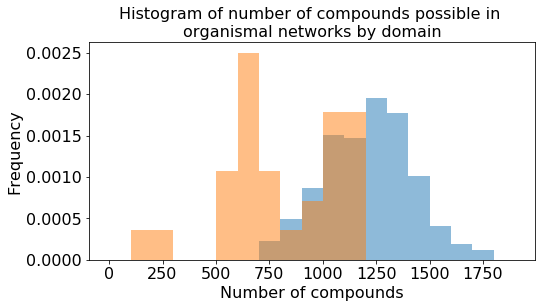

In [91]:
ax = merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_compounds"].plot.hist(alpha=.5,bins=range(1,2000,100),normed=True,figsize=(8,4),legend=False)
merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="archaea"]["n_scope_compounds"].plot.hist(alpha=.5,bins=range(1,2000,100),normed=True,legend=False)

ax.set_title("Histogram of number of compounds possible in \norganismal networks by domain",fontsize=16)
ax.set_xlabel("Number of compounds")

Text(0, 0.5, 'Fraction of scope compounds')

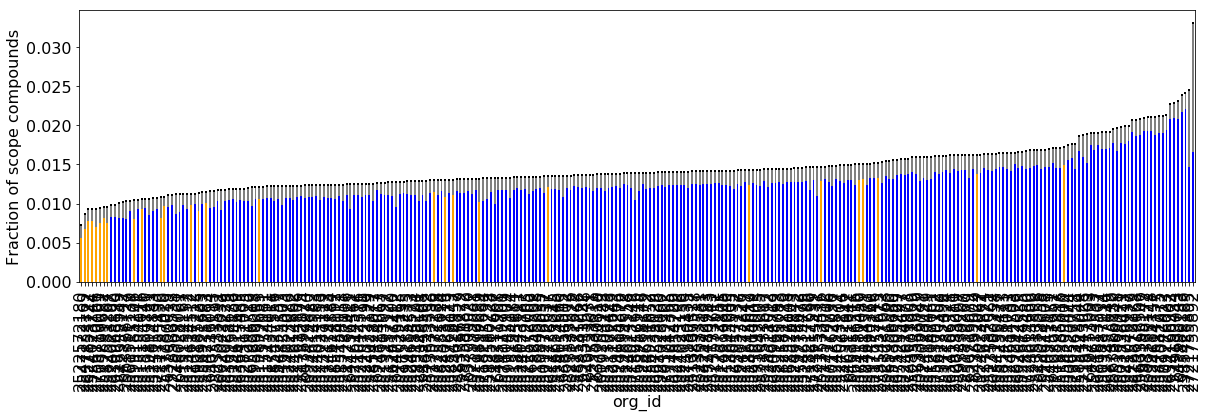

In [92]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
ax = (cpd_cump/cpd_scope).sort_values().plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=2),figsize=(20,5),color="gray")
ax2 = (cpd_cum/cpd_scope).reindex((cpd_cump/cpd_scope).sort_values().index).plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)

ax.set_ylabel("Fraction of scope compounds")


#### testing if commands work...

In [93]:
myseries = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().transpose()

In [94]:
max(pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values())

29

In [95]:
myseries

org_id
2721755892     121
2721755895     204
2718217665     528
2721755431     545
2718217646     575
2718217667     604
2739367758     625
644736412      628
644736411      642
650716079      679
2718217664     681
2718217666     683
2721755430     739
638154515      740
2599185174     751
2524023091     753
2599185232     756
2740891997     759
2602042032     768
2546825502     773
2585428191     775
643692029      802
2728369738     805
2546825503     818
2565956519     829
648028058      832
2622736413     854
2756170166     857
2599185206     866
649633043      868
              ... 
2517572175    1464
2523533611    1464
2571042005    1464
2524614677    1465
2574180450    1467
2503538021    1470
2521172622    1471
2518645605    1478
2521172637    1484
2558309102    1499
2585427672    1499
2554235029    1505
2556921652    1505
2602042029    1511
2513237112    1514
2515154138    1521
2582581270    1527
2517287006    1527
2523533533    1528
2585428043    1533
2565956516    1534
27037

In [96]:
myseries_reversed = (pd.Series(myseries.index.values, index=myseries ))

In [97]:
myseries_reversed

n_scope_compounds
121     2721755892
204     2721755895
528     2718217665
545     2721755431
575     2718217646
604     2718217667
625     2739367758
628      644736412
642      644736411
679      650716079
681     2718217664
683     2718217666
739     2721755430
740      638154515
751     2599185174
753     2524023091
756     2599185232
759     2740891997
768     2602042032
773     2546825502
775     2585428191
802      643692029
805     2728369738
818     2546825503
829     2565956519
832      648028058
854     2622736413
857     2756170166
866     2599185206
868      649633043
           ...    
1464    2517572175
1464    2523533611
1464    2571042005
1465    2524614677
1467    2574180450
1470    2503538021
1471    2521172622
1478    2518645605
1484    2521172637
1499    2558309102
1499    2585427672
1505    2554235029
1505    2556921652
1511    2602042029
1514    2513237112
1521    2515154138
1527    2582581270
1527    2517287006
1528    2523533533
1533    2585428043
1534    25659

In [98]:
type(pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().transpose())

pandas.core.series.Series

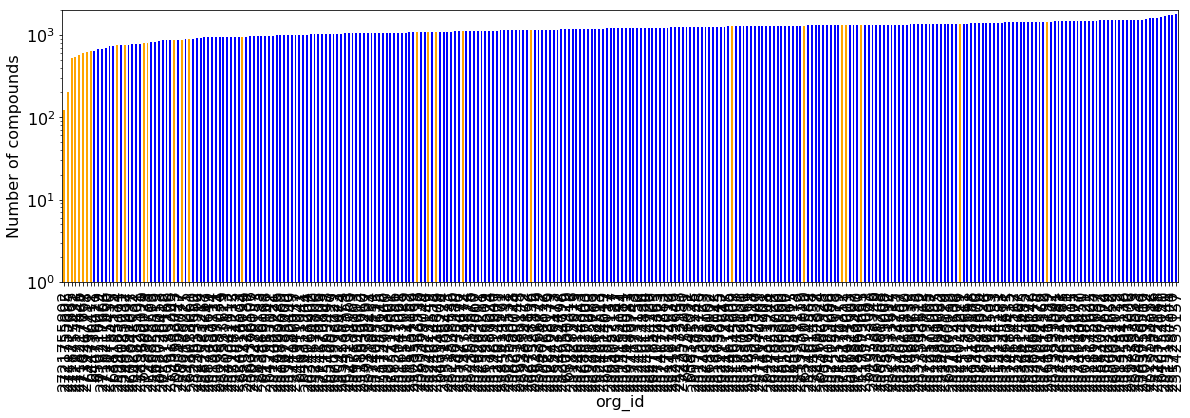

In [99]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(y="org_id",kind="bar",figsize=(20,5),color=color_rank_order)
# pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)
# pnp_df.groupby("org_id").min()["n_compounds_cumulative"].sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color="gray")
ax.set_ylabel("Number of compounds")
ax.set_ylim(1,2*10**3)
ax.set_yscale("log")


### List of all organism IDs used in study 

In [101]:
pnp_df.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P,n_compounds_cumulative_P,n_targets_cumulative_P,org_id_P,domain_P,n_scope_targets_P,n_scope_compounds_P,P_P
0,19,0,2554235157,bacteria,60,1800,False,22,0,2554235157,bacteria,60,1800,True
1,17,0,2517287020,bacteria,60,1749,False,19,0,2517287020,bacteria,60,1749,True
2,16,0,2515154141,bacteria,60,1727,False,18,0,2515154141,bacteria,60,1727,True
3,16,0,2515154140,bacteria,60,1698,False,18,0,2515154140,bacteria,60,1698,True
4,25,0,640753051,bacteria,60,1641,False,28,0,640753051,bacteria,60,1641,True


Text(0.5, 0, 'Number of compounds in scope')

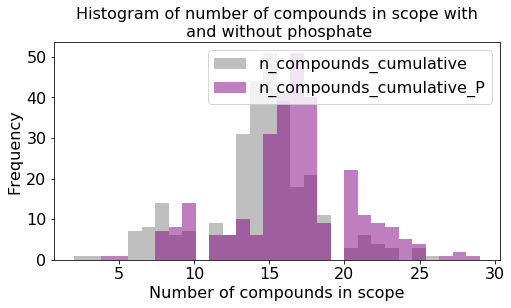

In [102]:
ax = pnp_df[['n_compounds_cumulative','n_compounds_cumulative_P']].plot.hist(alpha=.5,bins=30,legend=True,color=['grey','purple'],figsize=(8,4))
ax.set_title("Histogram of number of compounds in scope with\n and without phosphate",fontsize=16)
ax.set_xlabel("Number of compounds in scope")
# plt.

### Original figure below

Text(0.5, 0, 'Number of compounds in scope')

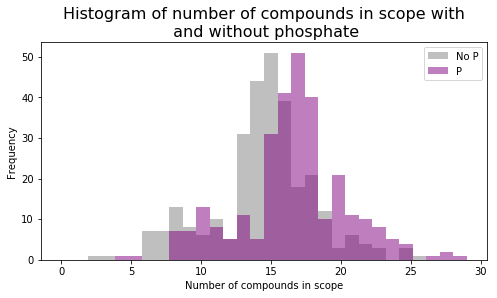

In [56]:
ax = pnp_df[['n_compounds_cumulative','n_compounds_cumulative_P']].plot.hist(alpha=.5,bins=30,legend=True,color=['grey','purple'],figsize=(8,4))
ax.set_title("Histogram of number of compounds in scope with\n and without phosphate",fontsize=16)
ax.set_xlabel("Number of compounds in scope")
# plt.

In [57]:
pd.pivot_table(merged_df_nophosphorous[['domain','n_scope_targets']],columns=["domain"])

domain,archaea,bacteria
n_scope_targets,50.785714,58.492481


In [58]:
merged_df_nophosphorous.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P
156,19,0,2554235157,bacteria,60,1861,False
28,17,0,2517287020,bacteria,60,1809,False
21,17,0,2515154141,bacteria,60,1786,False
20,16,0,2515154140,bacteria,60,1767,False
277,25,0,640753051,bacteria,60,1701,False


In [59]:
scope_targets_df = pd.DataFrame()

In [60]:
scope_targets_df["archaea"] = merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="archaea"]["n_scope_targets"]

In [61]:
# merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_targets"]

In [62]:
scope_targets_df["bacteria"] = merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_targets"]

In [63]:
len(scope_targets_df)

28

/Users/anarres/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/Users/anarres/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



Text(0.5, 0, 'Number of compounds in target set')

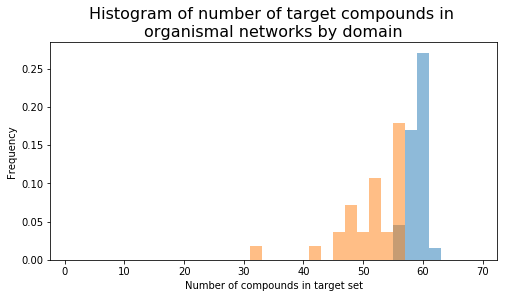

In [64]:
ax = merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_targets"].plot.hist(alpha=.5,bins=range(1,70,2),normed=True,legend=False,figsize=(8,4))
merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="archaea"]["n_scope_targets"].plot.hist(alpha=.5,bins=range(1,70,2),normed=True,legend=False)

ax.set_title("Histogram of number of target compounds in \norganismal networks by domain",fontsize=16)
ax.set_xlabel("Number of compounds in target set")

In [65]:
range(1,65,5)

range(1, 65, 5)

/Users/anarres/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



Text(0.5, 0, 'Number of compounds')

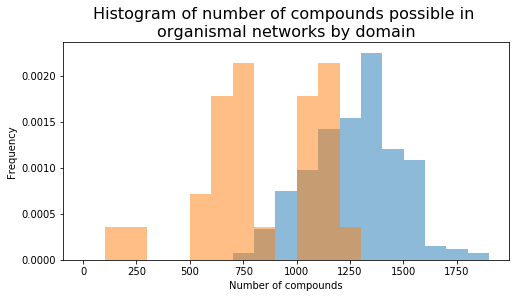

In [66]:
ax = merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_compounds"].plot.hist(alpha=.5,bins=range(1,2000,100),normed=True,figsize=(8,4),legend=False)
merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="archaea"]["n_scope_compounds"].plot.hist(alpha=.5,bins=range(1,2000,100),normed=True,legend=False)

ax.set_title("Histogram of number of compounds possible in \norganismal networks by domain",fontsize=16)
ax.set_xlabel("Number of compounds")

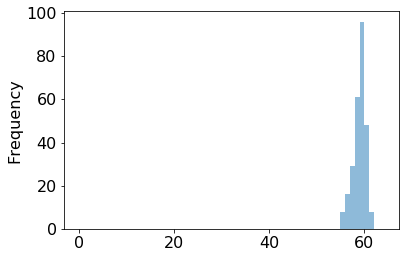

In [361]:
merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_targets"].plot.hist(alpha=.5,bins=range(65),legend=False)


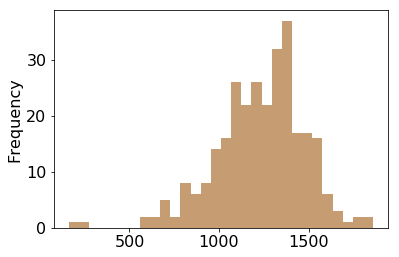

In [307]:
pnp_df[['n_scope_compounds','n_scope_compounds_P']].plot.hist(alpha=.5,bins=30,legend=False)

In [ ]:
pnp_df[['n_compounds_cumulative','n_scope_targets','n_scope_compounds']].hist(alpha=.5,bins=50)

In [176]:
stats_dicts[0].keys()

['domain',
 u'scope_seeds',
 u'scope_targets',
 'org_id',
 u'scope_compounds',
 'path',
 u'scope_reactions']

(array([   2.,    0.,    2.,   13.,   46.,  173.,   23.,   12.,   14.,    9.]),
 array([  3. ,   4.2,   5.4,   6.6,   7.8,   9. ,  10.2,  11.4,  12.6,
         13.8,  15. ]),
 <a list of 10 Patch objects>)

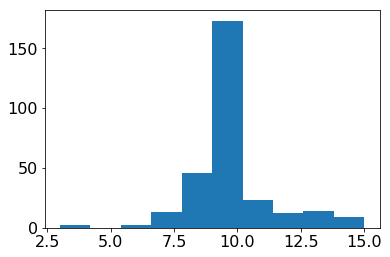

In [177]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([   1.,    0.,    0.,    1.,    2.,    4.,    8.,   19.,  107.,  152.]),
 array([ 32. ,  34.9,  37.8,  40.7,  43.6,  46.5,  49.4,  52.3,  55.2,
         58.1,  61. ]),
 <a list of 10 Patch objects>)

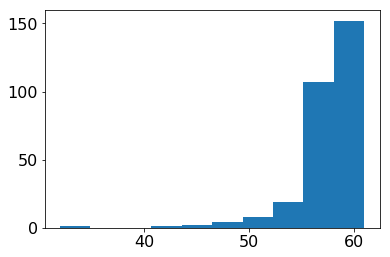

In [178]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([  2.,   0.,   4.,  15.,  28.,  64.,  80.,  71.,  25.,   5.]),
 array([  161.,   331.,   501.,   671.,   841.,  1011.,  1181.,  1351.,
         1521.,  1691.,  1861.]),
 <a list of 10 Patch objects>)

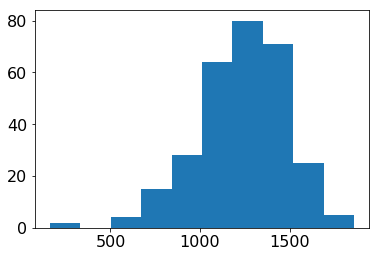

In [179]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([  2.,   2.,   7.,   8.,  26.,  67.,  64.,  80.,  33.,   5.]),
 array([   85. ,   247.2,   409.4,   571.6,   733.8,   896. ,  1058.2,
         1220.4,  1382.6,  1544.8,  1707. ]),
 <a list of 10 Patch objects>)

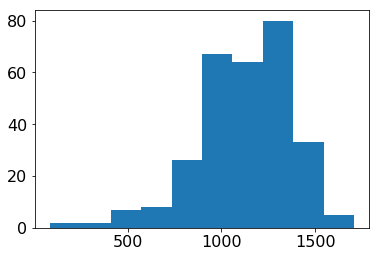

In [180]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

In [181]:
# cool_plots_many(df,'n_compounds_new')

In [182]:
# cool_plots_many(df,'n_compounds_cumulative')

In [183]:
# cool_plots_many(df,'n_targets_cumulative')

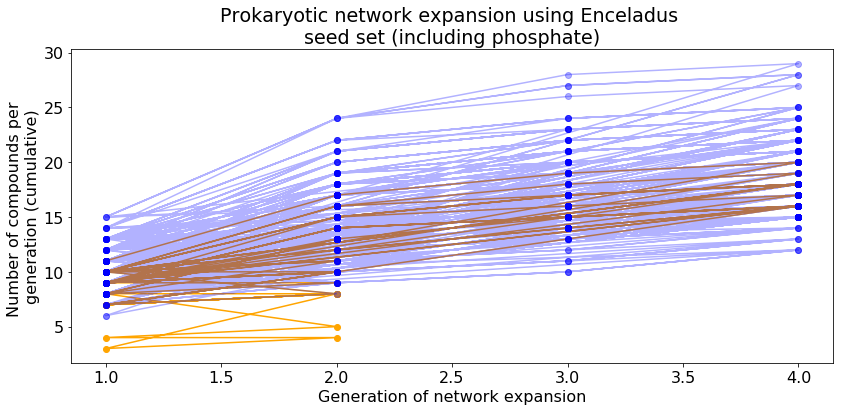

In [186]:
ax = df.loc[df["domain"]=="archaea"].reset_index().plot(kind="line",x="index",y="n_compounds_cumulative", style='-o',color="orange",figsize=(12,6),legend=False)
df.loc[df["domain"]=="bacteria"].reset_index().plot(kind="line",x="index",y="n_compounds_cumulative", style='-o',color="blue",ax=ax, alpha=.3,legend=False)

ax.set_title("Prokaryotic network expansion using Enceladus \nseed set (including phosphate)")
ax.set_xlabel("Generation of network expansion")
ax.set_ylabel("Number of compounds per \ngeneration (cumulative)")
plt.tight_layout()

## Using all KEGGs reactions

In [104]:
def read_formatted_json_single_allkegg(INDIR):
    generation_dfs = []
    stats_dicts = []
    
#     for domain in os.listdir(INDIR):
    for fname in glob.glob(INDIR+"*.json"):

        org_id = os.path.basename(fname).strip(".json")

        with open(fname) as f:
            datajson = json.load(f)

        datajson["stats"]["org_id"] = org_id
#         datajson["stats"]["domain"] = domain
        datajson["stats"]["path"] = fname

        stats_dicts.append(datajson["stats"])
        generation_dfs.append(pd.DataFrame(datajson["generations"]))
            
    return generation_dfs, stats_dicts

In [106]:
INDIR = "../results/formatted_2019-09-09/kegg_edge_json_P/"

generation_dfs, stats_dicts = read_formatted_json_single_allkegg(INDIR)
# print len(generation_dfs)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
# generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = generation_dfs[0]

In [194]:
INDIR = "../results/formatted_2019-09-09/kegg_edge_json/"

generation_dfs, stats_dicts = read_formatted_json_single_allkegg(INDIR)
# print len(generation_dfs)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
# generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
dfnp = generation_dfs[0]

In [107]:
len(stats_dicts[0])

6

In [108]:
df.head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new
1,"[C00001, C00009, C01326, C00132, C00067, C0001...","[C06547, C20783, C01548, C00014, C00011, C0006...","[R10092, R00067, R00132, R02359, R10538, R0538...","[R00005, R10535, R07316, R10079, R00067, R1053...",[],[],19,19,19,19,0,0
2,"[C00001, C00080, C00007, C00026, C00009, C0132...","[C00080, C00007, C00026, C00013, C00288, C0535...","[R10092, R00608, R00279, R00748, R00138, R0006...","[R00608, R00279, R00748, R00138, R03546, R0478...",[],[],39,20,50,31,0,0
3,"[C00001, C00080, C00007, C00026, C00009, C0132...","[C00025, C00704, C00022, C00346, C00222, C0021...","[R00782, R10092, R06870, R00608, R00258, R0027...","[R00782, R06870, R00258, R00008, R01874, R0025...",[C00025],[C00025],62,23,113,63,1,1
4,"[C00001, C00080, C00007, C00026, C00009, C0004...","[C00048, C02798, C00036, C00546, C00097, C0006...","[R00340, R04051, R00363, R00782, R10092, R1017...","[R00340, R04051, R00363, R10178, R02914, R0727...","[C00025, C00097, C00065, C00064, C00041]","[C00097, C00065, C00064, C00041]",119,57,238,125,5,4
5,"[C00001, C00080, C00007, C02107, C00026, C0000...","[C02107, C03826, C00383, C00957, C01732, C0003...","[R00340, R09186, R03106, R04051, R03694, R0036...","[R09186, R03106, R03694, R01267, R03966, R0696...","[C00025, C00097, C00037, C00065, C00064, C0004...","[C00037, C00049]",201,82,346,108,7,2


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([18.5, 18.6, 18.7, 18.8, 18.9, 19. , 19.1, 19.2, 19.3, 19.4, 19.5]),
 <a list of 10 Patch objects>)

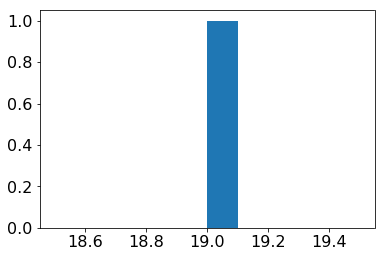

In [109]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([62.5, 62.6, 62.7, 62.8, 62.9, 63. , 63.1, 63.2, 63.3, 63.4, 63.5]),
 <a list of 10 Patch objects>)

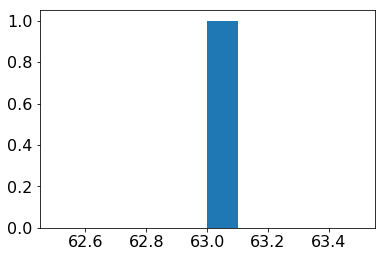

In [110]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([8072.5, 8072.6, 8072.7, 8072.8, 8072.9, 8073. , 8073.1, 8073.2,
        8073.3, 8073.4, 8073.5]),
 <a list of 10 Patch objects>)

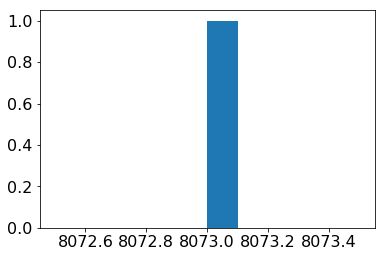

In [111]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([9933.5, 9933.6, 9933.7, 9933.8, 9933.9, 9934. , 9934.1, 9934.2,
        9934.3, 9934.4, 9934.5]),
 <a list of 10 Patch objects>)

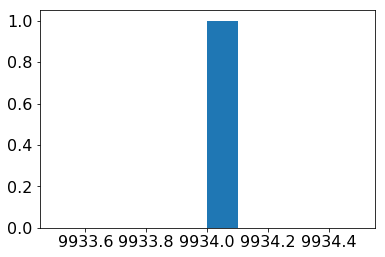

In [112]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

In [114]:
# cool_plots_many(df,'n_compounds_new')

In [115]:
# cool_plots_many(df,'n_compounds_cumulative')

In [116]:
# cool_plots_many(df,'n_targets_cumulative')

In [117]:
cool_plots(df,'n_compounds_new','n_targets_cumulative')

Text(0.5, 0, 'Generation of network expansion')

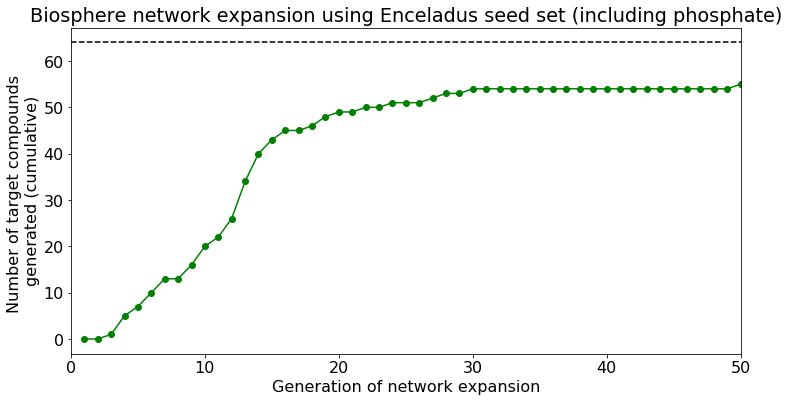

In [174]:
ax = df.reset_index().plot(kind="line",x="index",y="n_targets_cumulative",style='-o',legend=False,figsize=(12,6),c='g')
plt.axhline(y=64,c='k',linestyle='--')

ax.set_xlim(0,50)
ax.set_title("Biosphere network expansion using Enceladus seed set (including phosphate)")
ax.set_ylabel("Number of target compounds \ngenerated (cumulative)")
ax.set_xlabel("Generation of network expansion")


Let's generate this again but add 1 to each generation (because water was left out)

In [184]:
df["n_targets_cumulative"] = df["n_targets_cumulative"]+1

In [189]:
df[["n_targets_cumulative"]].tail(7)

,n_targets_cumulative
49,55
50,56
51,56
52,56
53,56
54,56
55,56


Text(0.5, 0, 'Generation of network expansion')

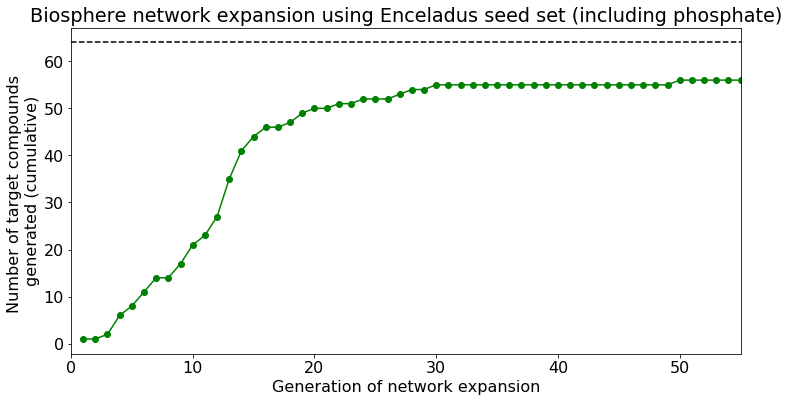

In [190]:
ax = df.reset_index().plot(kind="line",x="index",y="n_targets_cumulative",style='-o',legend=False,figsize=(12,6),c='g')
plt.axhline(y=64,c='k',linestyle='--')

ax.set_xlim(0,55)
ax.set_title("Biosphere network expansion using Enceladus seed set (including phosphate)")
ax.set_ylabel("Number of target compounds \ngenerated (cumulative)")
ax.set_xlabel("Generation of network expansion")


In [192]:
df.tail(2)

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new
54,"[C01832, C00016, C00001, C17224, C00024, C0000...","[C02041, C01530, C02744]","[R03857, R08640, R00340, R02433, R01081, R0815...",[R08175],"[C00016, C00024, C00005, C00003, C00035, C0000...",[],3883,3,5543,1,56,0
55,"[C01832, C00016, C00001, C17224, C00024, C0000...",[C06425],"[R03857, R08640, R00340, R02433, R01081, R0815...",[],"[C00016, C00024, C00005, C00003, C00035, C0000...",[],3884,1,5543,0,56,0


In [196]:
dfnp.head(2)

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new
1,"[C00001, C01326, C00132, C00067, C00014, C1150...","[C06547, C20783, C01548, C00014, C00011, C0006...","[R10092, R00067, R00132, R02359, R10538, R0538...","[R00005, R10535, R07316, R10079, R00067, R1053...",[],[],18,18,18,18,0,0
2,"[C00001, C00080, C00007, C00026, C01326, C0013...","[C00080, C00007, C00026, C00288, C05359, C0002...","[R10092, R00608, R00279, R00067, R03546, R0013...","[R00608, R00279, R03546, R04782, R00276, R0077...",[],[],37,19,45,27,0,0


In [195]:
dfnp.tail(2)

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new
25,"[C00001, C00080, C00007, C02107, C00506, C0002...","[C20918, C20919]","[R00340, R02433, R09186, R10908, R05781, R0310...",[R10894],"[C00025, C00097, C00037, C00065, C00064, C0008...",[],804,2,983,1,17,0
26,"[C00001, C00080, C00007, C02107, C00506, C0002...",[C20920],"[R00340, R02433, R09186, R10908, R05781, R0310...",[],"[C00025, C00097, C00037, C00065, C00064, C0008...",[],805,1,983,0,17,0


### Which compounds are included in the no-phosphate enceladus expansion? where do they differ from ones that john sees?

In [209]:
my_enc_compounds = list(dfnp.tail(1)["compounds_cumulative"].items())[0][1]

In [226]:
with open("../../EncXP/enc_exp0.json") as f:
    johns_enc_all = json.load(f)

In [230]:
johns_enc_compounds = johns_enc_all["generations"]['26']['compounds_cumulative']

In [231]:
set(my_enc_compounds)^set(johns_enc_compounds)

{'C06177', 'C12440'}

In [232]:
set(johns_enc_compounds)-set(my_enc_compounds)

{'C06177', 'C12440'}

Ok.... need to check if these are in the KEGG file I used for analyses

In [237]:
with open("../kegg/2018-09-25/compound.json") as f:
    kegg2018compounds = json.load(f)

In [241]:
kegg2018compoundsclean = [c.strip("cpd:") for c in kegg2018compounds.keys()]

In [243]:
'C12440' in kegg2018compoundsclean

True

Why are these here???????

In [124]:
df.head(2)

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new
1,"[C00001, C00009, C01326, C00132, C00067, C0001...","[C06547, C20783, C01548, C00014, C00011, C0006...","[R10092, R00067, R00132, R02359, R10538, R0538...","[R00005, R10535, R07316, R10079, R00067, R1053...",[],[],19,19,19,19,0,0
2,"[C00001, C00080, C00007, C00026, C00009, C0132...","[C00080, C00007, C00026, C00013, C00288, C0535...","[R10092, R00608, R00279, R00748, R00138, R0006...","[R00608, R00279, R00748, R00138, R03546, R0478...",[],[],39,20,50,31,0,0


In [122]:
df.tail(10)

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new
46,"[C01832, C00016, C00001, C17224, C00024, C0000...","[C05259, C06736, C06737]","[R03857, R08640, R00340, R02433, R01081, R0815...",[R04737],"[C00016, C00024, C00005, C00003, C00035, C0000...",[],3854,3,5507,1,54,0
47,"[C01832, C00016, C00001, C17224, C00024, C0000...",[C05258],"[R03857, R08640, R00340, R02433, R01081, R0815...",[R04738],"[C00016, C00024, C00005, C00003, C00035, C0000...",[],3855,1,5508,1,54,0
48,"[C01832, C00016, C00001, C17224, C00024, C0000...",[C05272],"[R03857, R08640, R00340, R02433, R01081, R0815...","[R01279, R01278]","[C00016, C00024, C00005, C00003, C00035, C0000...",[],3856,1,5510,2,54,0
49,"[C01832, C00016, C00001, C17224, C00024, C0000...",[C00154],"[R03857, R08640, R00340, R02433, R01081, R0815...","[R01281, R01274, R01277, R02138, R07758, R01280]","[C00016, C00024, C00005, C00003, C00035, C0000...",[],3857,1,5516,6,54,0
50,"[C01832, C00016, C00001, C17224, C00024, C0000...","[C00517, C02934, C00249, C16216, C02536]","[R03857, R08640, R00340, R02433, R01081, R0815...","[R01704, R02978, R04092, R01703, R02462, R0246...","[C00016, C00024, C00005, C00003, C00035, C0000...",[C00249],3862,5,5525,9,55,1
51,"[C01832, C00016, C00001, C17224, C00024, C0000...","[C16217, C01120, C00836, C18218, C00823, C0612...","[R03857, R08640, R00340, R02433, R01081, R0815...","[R07760, R06520, R02979, R02976, R09448, R0910...","[C00016, C00024, C00005, C00003, C00035, C0000...",[],3870,8,5533,8,55,0
52,"[C01832, C00016, C00001, C17224, C00024, C0000...","[C00319, C19614, C16218, C06124, C18217, C08285]","[R03857, R08640, R00340, R02433, R01081, R0815...","[R01929, R09457, R07761, R01926, R06521, R01928]","[C00016, C00024, C00005, C00003, C00035, C0000...",[],3876,6,5539,6,55,0
53,"[C01832, C00016, C00001, C17224, C00024, C0000...","[C00412, C03640, C01747, C19615]","[R03857, R08640, R00340, R02433, R01081, R0815...","[R03700, R08174, R02224]","[C00016, C00024, C00005, C00003, C00035, C0000...",[],3880,4,5542,3,55,0
54,"[C01832, C00016, C00001, C17224, C00024, C0000...","[C02041, C01530, C02744]","[R03857, R08640, R00340, R02433, R01081, R0815...",[R08175],"[C00016, C00024, C00005, C00003, C00035, C0000...",[],3883,3,5543,1,55,0
55,"[C01832, C00016, C00001, C17224, C00024, C0000...",[C06425],"[R03857, R08640, R00340, R02433, R01081, R0815...",[],"[C00016, C00024, C00005, C00003, C00035, C0000...",[],3884,1,5543,0,55,0


In [121]:
targets_Freilich09=["C00001",
    "C00002",
    "C00003",
    "C00004",
    "C00005",
    "C00006",
    "C00008",
    "C00015",
    "C00016",
    "C00020",
    "C00024",
    "C00025",
    "C00035",
    "C00037",
    "C00041",
    "C00043",
    "C00044",
    "C00047",
    "C00049",
    "C00054",
    "C00055",
    "C00062",
    "C00063",
    "C00064",
    "C00065",
    "C00073",
    "C00075",
    "C00078",
    "C00079",
    "C00082",
    "C00097",
    "C00105",
    "C00112",
    "C00116",
    "C00123",
    "C00131",
    "C00135",
    "C00144",
    "C00148",
    "C00152",
    "C00183",
    "C00188",
    "C00234",
    "C00239",
    "C00249",
    "C00255",
    "C00286",
    "C00350",
    "C00360",
    "C00362",
    "C00364",
    "C00399",
    "C00407",
    "C00458",
    "C00459",
    "C00641",
    "C00748",
    "C01050",
    "C05764",
    "C05890",
    "C05894",
    "C05899",
    "C05980",
    "C06040",
    "C15672",
    "C16221"]

In [125]:
kegg_targets_cumulative = df.iloc[50]["targets_cumulative"]

In [128]:
kegg_targets_cumulative

['C00016',
 'C00024',
 'C00005',
 'C00003',
 'C00035',
 'C00002',
 'C00025',
 'C00004',
 'C00008',
 'C00006',
 'C00063',
 'C00097',
 'C00037',
 'C00065',
 'C00064',
 'C00044',
 'C00082',
 'C00148',
 'C00152',
 'C00047',
 'C00123',
 'C00135',
 'C00020',
 'C00078',
 'C00183',
 'C00041',
 'C00079',
 'C00062',
 'C01050',
 'C00055',
 'C00407',
 'C00043',
 'C00049',
 'C00015',
 'C00188',
 'C00364',
 'C00458',
 'C00075',
 'C00131',
 'C00234',
 'C00239',
 'C00073',
 'C00255',
 'C00286',
 'C00116',
 'C00144',
 'C00399',
 'C00112',
 'C00105',
 'C00360',
 'C00249',
 'C00459',
 'C00362',
 'C00054',
 'C05894']

In [176]:
len(kegg_targets_cumulative)

55

In [126]:
# df.iloc[41]["targets_cumulative"]

In [130]:
df.iloc[0]["compounds_cumulative"]

['C00001',
 'C00009',
 'C01326',
 'C00132',
 'C00067',
 'C00014',
 'C11505',
 'C01407',
 'C00697',
 'C00283',
 'C00011',
 'C00282',
 'C06547',
 'C00237',
 'C00469',
 'C20783',
 'C01438',
 'C06548',
 'C01548']

In [133]:
set(df.iloc[0]["compounds_new"]) == set(df.iloc[0]["compounds_cumulative"])

True

In [177]:
len(targets_Freilich09)

66

In [178]:
targets_Freilich09

['C00001',
 'C00002',
 'C00003',
 'C00004',
 'C00005',
 'C00006',
 'C00008',
 'C00015',
 'C00016',
 'C00020',
 'C00024',
 'C00025',
 'C00035',
 'C00037',
 'C00041',
 'C00043',
 'C00044',
 'C00047',
 'C00049',
 'C00054',
 'C00055',
 'C00062',
 'C00063',
 'C00064',
 'C00065',
 'C00073',
 'C00075',
 'C00078',
 'C00079',
 'C00082',
 'C00097',
 'C00105',
 'C00112',
 'C00116',
 'C00123',
 'C00131',
 'C00135',
 'C00144',
 'C00148',
 'C00152',
 'C00183',
 'C00188',
 'C00234',
 'C00239',
 'C00249',
 'C00255',
 'C00286',
 'C00350',
 'C00360',
 'C00362',
 'C00364',
 'C00399',
 'C00407',
 'C00458',
 'C00459',
 'C00641',
 'C00748',
 'C01050',
 'C05764',
 'C05890',
 'C05894',
 'C05899',
 'C05980',
 'C06040',
 'C15672',
 'C16221']

In [127]:
set(targets_Freilich09) - set(kegg_targets_cumulative)

{'C00001',
 'C00350',
 'C00641',
 'C00748',
 'C05764',
 'C05890',
 'C05899',
 'C05980',
 'C06040',
 'C15672',
 'C16221'}

In [146]:
(set(targets_Freilich09) - set(kegg_targets_cumulative))

{'C00001',
 'C00350',
 'C00641',
 'C00748',
 'C05764',
 'C05890',
 'C05899',
 'C05980',
 'C06040',
 'C15672',
 'C16221'}

In [134]:
(set(targets_Freilich09) - set(kegg_targets_cumulative))-set(df.iloc[0]["compounds_cumulative"])

{'C00350',
 'C00641',
 'C00748',
 'C05764',
 'C05890',
 'C05899',
 'C05980',
 'C06040',
 'C15672',
 'C16221'}

> KEGG Doesn't even have C05890 C05899 in Current version Oct 12
> The expansion is missing Siroheme, a large compound found in Porphyrin and chlorophyll metabolism, Metabolic pathways, Biosynthesis of secondary metabolites; Heme, a coenzyme common in metabolism. 
> Update on what is missing:
- 'C00350', Phosphatidylethanolamine (lipid)
- 'C00641', 1,2-Diacyl-sn-glycerol (lipid)
- 'C00748', Siroheme
- 'C05764', Hexadecanoyl-[acp] (lipid)
- 'C05980', Cardiolipin (lipid)
- 'C06040', Diglucosyldiacylglycerol (lipid)
- 'C15672', Heme O
- 'C16221', (2E)-Octadecenoyl-[acp]; (lipid)


> Need to check which compounds are even reachable, given the element balanced reactions

In [135]:
with open("../kegg/2018-09-25/reaction_edges.json") as f:
    reaction_edges = json.load(f)

In [139]:
reachable_compounds = []
for side in reaction_edges:
    for r in reaction_edges[side]:
        reachable_compounds+=reaction_edges[side][r]

In [142]:
len(set(reachable_compounds))

8073

In [144]:
set(targets_Freilich09)-set(reachable_compounds)

{'C05890', 'C05899'}

> Only two unreachable compounds are those that aren't in latest version of kegg

In [145]:
len(set(targets_Freilich09))

66

> There are 64 in-theory reachable compounds from freilich

In [147]:
reaction_edges

{'products': {'R07881': ['C14101', 'C00010'],
  'R07880': ['C16349', 'C00010'],
  'R08252': ['C16623'],
  'R10504': ['C01769', 'C00004', 'C00080'],
  'R07882': ['C16350', 'C00010'],
  'R07885': ['C16289', 'C00010'],
  'R11544': ['C21336', 'C00936'],
  'R07884': ['C16288', 'C00010'],
  'R10096': ['C00015', 'C20353'],
  'R07887': ['C00020', 'C00013', 'C16327'],
  'R11422': ['C00363', 'C11469'],
  'R07886': ['C16290', 'C00010'],
  'R10505': ['C00810', 'C00004', 'C00080'],
  'R08859': ['C06740', 'C00015'],
  'R10097': ['C04706', 'C01327'],
  'R08858': ['C04724', 'C00035'],
  'R11130': ['C20955', 'C01352'],
  'R10094': ['C20351', 'C00025'],
  'R10507': ['C03912', 'C01352'],
  'R09679': ['C00021', 'C19807'],
  'R11131': ['C21131'],
  'R01007': ['C00105', 'C04500'],
  'R01006': ['C00110', 'C00031'],
  'R01005': ['C00015', 'C01246'],
  'R01004': ['C00110', 'C00009'],
  'R01003': ['C00381', 'C00009'],
  'R01001': ['C00097', 'C00014', 'C00109'],
  'R01000': ['C00109', 'C00004', 'C00080'],
  'R01

In [148]:
import networkx as nx

In [150]:
B = nx.Graph()

In [151]:
for side in reaction_edges:
    for r in reaction_edges[side]:
        B.add_node(r,bipartite=0)
        for c in reaction_edges[side][r]:
            B.add_node(c,bipartite=1)
            B.add_edge(r,c)

In [157]:
nx.is_bipartite(B)

True

In [161]:
# nx.draw(B)

In [166]:
unreachable_compounds = list((set(targets_Freilich09) - set(kegg_targets_cumulative))-set(df.iloc[0]["compounds_cumulative"]))

In [167]:
unreachable_compounds

['C00350',
 'C16221',
 'C05980',
 'C05890',
 'C06040',
 'C15672',
 'C05764',
 'C00641',
 'C05899',
 'C00748']

In [169]:
set(['C00350', 'C16221']) & set(unreachable_compounds)

{'C00350', 'C16221'}

> Check to see if unreachable compounds are outside of the largest connected component

In [170]:
[set(unreachable_compounds)&set(sg) for sg in nx.connected_components(B) if len(sg)<10]

[set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set()]

> They're not

In [175]:
reachable_compounds

['C14101',
 'C00010',
 'C16349',
 'C00010',
 'C16623',
 'C01769',
 'C00004',
 'C00080',
 'C16350',
 'C00010',
 'C16289',
 'C00010',
 'C21336',
 'C00936',
 'C16288',
 'C00010',
 'C00015',
 'C20353',
 'C00020',
 'C00013',
 'C16327',
 'C00363',
 'C11469',
 'C16290',
 'C00010',
 'C00810',
 'C00004',
 'C00080',
 'C06740',
 'C00015',
 'C04706',
 'C01327',
 'C04724',
 'C00035',
 'C20955',
 'C01352',
 'C20351',
 'C00025',
 'C03912',
 'C01352',
 'C00021',
 'C19807',
 'C21131',
 'C00105',
 'C04500',
 'C00110',
 'C00031',
 'C00015',
 'C01246',
 'C00110',
 'C00009',
 'C00381',
 'C00009',
 'C00097',
 'C00014',
 'C00109',
 'C00109',
 'C00004',
 'C00080',
 'C00035',
 'C03862',
 'C00015',
 'C04678',
 'C01227',
 'C00033',
 'C03161',
 'C00001',
 'C03765',
 'C00218',
 'C03765',
 'C00014',
 'C00013',
 'C04121',
 'C01187',
 'C00009',
 'C03845',
 'C01188',
 'C00010',
 'C01190',
 'C00124',
 'C01290',
 'C00015',
 'C01192',
 'C00005',
 'C00080',
 'C00110',
 'C02399',
 'C00060',
 'C00151',
 'C01419',
 'C03740',